<a href="https://colab.research.google.com/github/HyeSeong-Lee/NLP-DialoGPT/blob/main/DialoChat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dialo GPT

### 1. 모델 작동방식
이전 과제에서 언급했던 Auto Regressive 방식을 기억하실 겁니다.
Remind를 위해 잠시 다시 설명드리자면,

토큰 벡터가 $W=[w_1, w_2,...w_n]$으로 정의될 때,

$P(w)=∏_{i=1}^{t-1}P(w_i|w_1,w_2,...,w_{i-1})$

로 정의합니다. 이에 대해 부연설명을 드리자면,

P(첫번째 단어)는 단순히 첫번째 단어가 나올 확률이고,

P(두번째 단어)를 구할 때,

이미 첫번째 단어가 발생한 상황에서 두번째 단어에 대한 확률을 구하므로,
$P(첫번째 단어)P(두번째 단어|첫번째 단어)$가 두번째 단어에 대한 확률을 말합니다.

이러한 과정을 마지막 단어까지 계속 반복하는 방식이고,

방금 예시로 든 사례처럼 첫번째 단어부터 마지막 단어까지 가면 순방향,

마지막 단어에서 첫번째 단어로 오면 역방향이라고 합니다.

Dialo GPT모델은 이름과 걸맞게 GPT-2모델을 기반으로 만들어졌습니다(논문에서는 상속받았다고 표현). GPT-2 모델이 Auto Regressive 방식을 취하기에 Dialo GPT도 Auto Regressive방식을 사용합니다.

논문에서는 sequence가 $x_1, x_2,...,x_N$으로 주어졌다고 했을 때, 앞에서 부터 m개의 sequence의 집합을 Source sentence(S)라고 정의하고 m+1번째 부터 N번째의 Sequence를 Target sentence(T)라고 정의합니다. 이를 식으로 표현하면 아래와 같습니다.

$S= x_1, x_2,...x_m$

$T=x_{m+1}, x_{m+2}...x_N$


이때, Auto Regressive 방식을 도입해 $P(T|S)$를 구하며 Source sentence를 가지고 적절한 Target sentence를 구하는 것입니다. 수식으로 표현하면 아래와 같습니다.

$P(T|S)=∏_{i=m+1}^NP(x_i|x_1,...,x_{i-1})$

$P(T|S)$를 likelihood로 여기고, 이에 log를 취해 log likelihood로 만든 후 Maximun likelihood방식을 취하면, 모델에서 예측하는 Target sentence($T\prime$)은 아래와 같이 정의할 수 있습니다.

$T\prime=argmax_T(log(P(T|S)))$

이는 나름 교과서적인 해결 방안이지만, 단조롭거나 정보를 별로 담고있지 않은 대답을 하는 문제점이 있습니다. 그 이유는 S에서 T에 대한 확률을 계산해 대답을 하긴 하지만, T에서 S에 대한 확률은 전혀 고려하지 않기 때문입니다. 따라서, Dialo GPT에서는 단순히 Auto Regressive 방식으로 $P(T|S)$를 구한 다음 단순히 이를 통해 maximum likelihood를 수행한다기 보다는, maximum mutual information(MMI)방식을 수행합니다.

이 맥락에서 MMI를 수행한다라고 함은 S와 T간의 상호 정보를 최대화하는 것을 말하는 것입니다. 즉, $P(T|S)$뿐만 아니라 $P(S|T)$도 활용한다는 것이고, 이 $P(S|T)$를 backward model이라고 논문은 설명합니다. 
Dialo GPT에서는 MMI가 아래와 다음과 같이 수행됩니다. 우선, top-K sampling을 통해 Hypothesis($H$)를 생성합니다($P(H|S)$). 그 후, $H$내부의 요소들을 re-rank하기 위해, $P(S|H)$를 backward model로 사용합니다. $P(S|H)$라는 likelihood를 최대화하게 되면, 앞서 언급한 단조롭거나 정보를 별로 담고있지 않은 대답에 대해 penalty를 주게 됩니다. 그 이유가 친절하게 설명되어있지 않아, 개인적으로 증명해보았고, 그것은 다음과 같습니다.

우선, $P(S|H)$에 대해 생각해 봅시다. $P(S|H)=\frac{P(S,H)}{P(H)}$입니다. 여기서 $P(S|H)$를 최대화하기 위해, $P(H)$를 최소화하면서, $P(S,H)$를 최대화하는 것이 바람직합니다. 좀 더 정확히 말하면, 분모는 작을수록 좋고, 분자는 클 수록 좋은 것입니다. 하지만, 불행이도, $P(H)$와 $P(S,H)$가 서로 독립이라는 가정도 없고, 또 그렇다는 보장도 없습니다. 그래서 다른 접근을 해본다면, ($P(H)$만 조정해도 나머지 계산이 가능할 수도 있지만 일단은)$P(H)$와 $P(S,H)$를 조정해 가며 $P(S|H)$를 계산합니다. 여기서 $P(H)$를 조정하면서 앞서 말한 답변을 제외할 수 있습니다. 예를들어, "글쎄요", "잘 모르겠는데요?"라는 답변은 날씨를 물어보던, 어제 축구의 승패 여부를 물어보던, 논문의 저자를 물어보던 대답이 되긴 합니다. 하지만, 우리가 모델에게 기대하는 답변이라고 보긴 어렵습니다. 즉, 저러한 답변의 경우 source에 상관없이 등장할 확률이 높다는 것입니다. 그러므로, top-K sampling을 한다면 당연히 그러한 대답이 상위에 rank되는 경우가 대부분일 것입니다. 앞서 언급했듯, 그러한 대답은 많은 source에 대해 대답이 되기 때문에 그러한 값들로 $H$를 구성하게 된다면 $P(H)$의 값은 높은 값을 가지게 되겠지요. 여기서 $P(H)$를 조금씩 낮춰보게 되면, 그러한 대답 말고, 더 낮은 확률로 계산된 "우리가 바라는 답변"을 만날 수도 있게 되는 것입니다. 이때, 문제를 해결하기 위해  $P(S,H)$또한 필요한 것입니다. $P(S,H)$는 $S$와 $H$가 동시에 등장했다는 것을 말하는데, 완벽하진 않아도, 응답의 정확성을 반영할 수 있습니다. 요약하자면, $P(H)$를 조정하면서, $P(S,H)$를 계산하고, 이에 대한 $P(S|H)$를 계속 구해보고, 구한 값 중 최댓값을 취하며, $P(S|H)$를 최대화하는 것인데, 이것이 의미하는 것은, 앞서 말한 답변보다 확률이 낮은 응답들을 한번씩 보면서, 이것이 S에 대해 얼마나 좋은 대답인지를 확인하고, 그 중에서 그나마 나은 대답을 찾아가겠다는 것입니다.

코드의 경우 다르게 구현되었지만, 알고 보니, 궁극적으로는 같은 기능을 하고 있었습니다. Dialo GPT 깃허브에서 제시한 chat bot 코드 중 가장 제가 설명한 것과 비슷한 코드로 설명드리겠습니다.

우선, main함수를 한번 봅시다. 아래 보이는 바와 같이 main은 user에게 입력받은 메시지를 리스트에 넣어 append_messages함수에 인자로 전달해줍니다. 이를 미루어 볼 때, 입력을 누적시키는 것은 append_list일 것입니다. 그 후, my_response에 generate_message의 output을 할당해 bot의 대답으로 활용합니다. 그럼 이제, 각 함수를 들여다 봅시다.

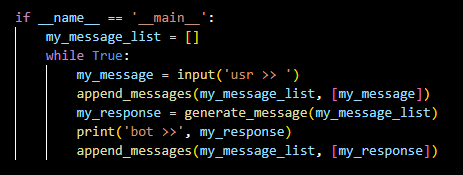

append_messages는 아래 보이는 바와 같이 새로 들어온 메시지를 빈 메시지가 아니라면 기존의 리스트에 추가해줍니다. 여기서 의문점이, 어차피 메시지는 하나씩 들어오는데, 굳이 반복문으로 구현해두었다는 겁니다. 결과상의 차이는 없고, 여러 메시지가 혹시라도 들어왔을 때 유용할 것이니 그런 기능 구현을 의도한 것 같습니다. 그 후 truncate코드가 나오는데, 이 부분을 구현한 이유는, 과거 나눴던 대화까지 반영해 대답하는 것을 시도하고자 나눴던 대화도 다 저장하는데, 너무 많은 대화를 하게 되면 응답 시간도 느려지고 오버헤드가 커집니다. 따라서, 너무 오래된 것은 오래된 순서대로 삭제해줍니다.

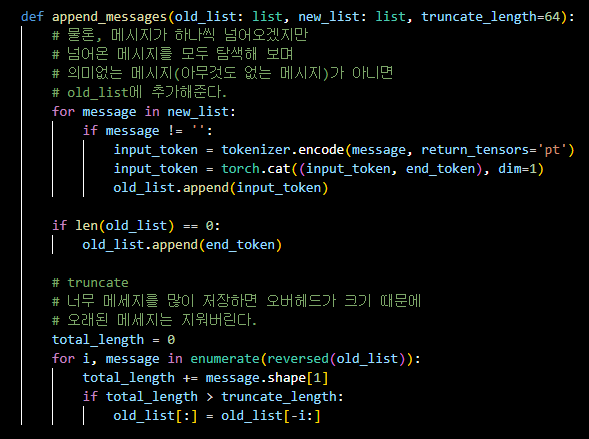

문장은 아래 사진에서 보이는 _get_response함수에서 만들어집니다. 이것을 먼저 설명드리는 이유는, generate_message에서 활용하기 때문에 먼저 설명이 필요하다고 생각이 들었기 때문입니다. 제가 달아놓은 주석에서 볼 수 있듯, 문장을 만들면서도 각 단어에 대해 top-k sampling을 진행하고, 그 K개를 softmax에 통과시켜 새로운 확률을 만들어냅니다. softmax에 넣어줌으로써, sampling한 K개의 단어의 확률을 모두 더하면 1이 되게 하고, 뽑히지 않은 단어들이 발생할 확률을 0으로 만들어주는 것입니다. 좀 더 정확하게 말하면, k개로 뽑힌 단어들의 경우 확률이 그대로 softmax에 들어가고, 뽑히지 않은 단어의 경우 아래 코드에서 보시는 것과 같이 -∞로 바뀌어 사실상 softmax에 들어가게 되면 0이 됩니다. 그렇게 되면 softmax에 들어가면 해서 K개의 단어가 발생한 확률이 정확히 1이라기 보다는 사실상 1이라는 결론에 도달하게 됩니다. 그런 확률을 기반으로 하나의 sample을 뽑아 그것을 만들고 있는 문장의 끝에 추가하고, 만약에 문장의 마지막을 알리는 시퀀스라면, 문장을 그만 만들고 만들어진 문장을 리턴해줍니다.

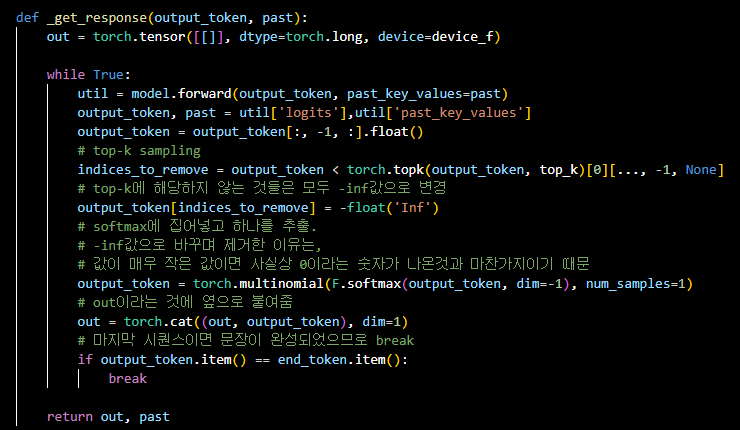

mutual information의 경우 아래 코드에서 보이는 바와 같이 _score_response에서 계산됩니다. 여기서 loss라는 값을 사용하기 위해 reverse_model이라는 클래스를 호출하는 것을 볼 수 있습니다. 이 클래스는 GPT2LMHEADMODEL이라는 클래스인데, 이것의 작동 방식은 사실상, 예측한 문장과 이전 문장 사이의 Cross Entropy값인데, 이는 두 문장 사이의 거리를 표현하는 것입니다. 거리는 가까울 수록 좋은 것이기 때문에, -1을 곱해 리턴해 주어, maximum mutual information을 진행할 때 cross entropy가 작은 것이 높은 점수를 가질 수 있도록 합니다.

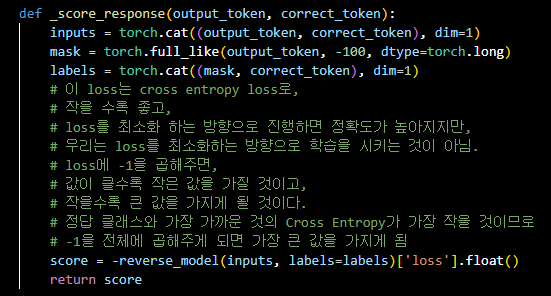

대답에 사용될 문장을 결정하는 부분이 이 generate_message 함수입니다. 여기서, total_input에 message_list를 넣어주는 것이 있는데, 이는 지금까지 나눈 대화의 history라고 보시면 됩니다. focus last message가 참이면, 마지막 메시지를 total_input_reversed에 넣어주는데, 코드상 focus last message가 거짓으로 전달되는 경우는 없습니다. 아무래도 마지막 메시지에만 집중하지 않아서 품질 좋은 답변을 만드려고 하는 시도인것 같습니다. 아무튼, 마지막 메시지를 기반으로 문장을 만들어 냅니다. 마지막 이전까지의 맥락과, 마지막 메시지를 가지고, 메시지를 만들어낸 다음 만들어낸 메시지를 가지고 점수를 계산하는 과정을 num_samples만큼 반복해 하나의 배열을 만들어냅니다. 여기서, 점수에 대한 정보가 들어있기 때문에, 점수들을 softmax에 넣은 다음, softmax의 값을 기준으로 sampling합니다. 즉, num_samples만큼의 문장을 만든 다음, 점수를 기반으로 확률을 만들어 확률적인 추출을 하는 것이지요. 다만, 제가 주석으로 달지 않은 부분에 argmax로 하는 부분이 있긴 한데, 코드 작성자가 이 부분을 주석으로 바꾸고 확률 추출을 사용한 것은 답변의 다양성을 확보하기 위한 의도로 보입니다.

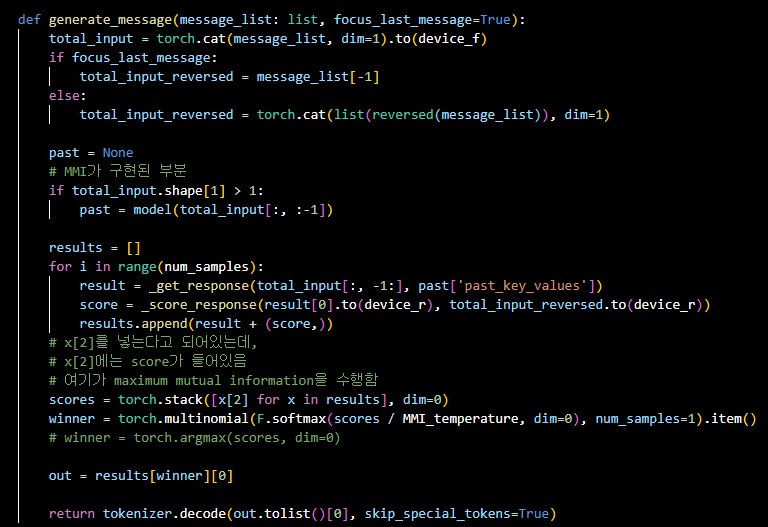

갑자기 모델에 대한 output을 쭉 건너뛰어 잠시 부록으로 추가하고자 합니다. 제가 밑에 작성한 코드에서 보시면 아시겠지만, 모든 모델은 GPT2LMHeadModel입니다. 그리고 해당 공식문서에 따르면, 아래와 같습니다.

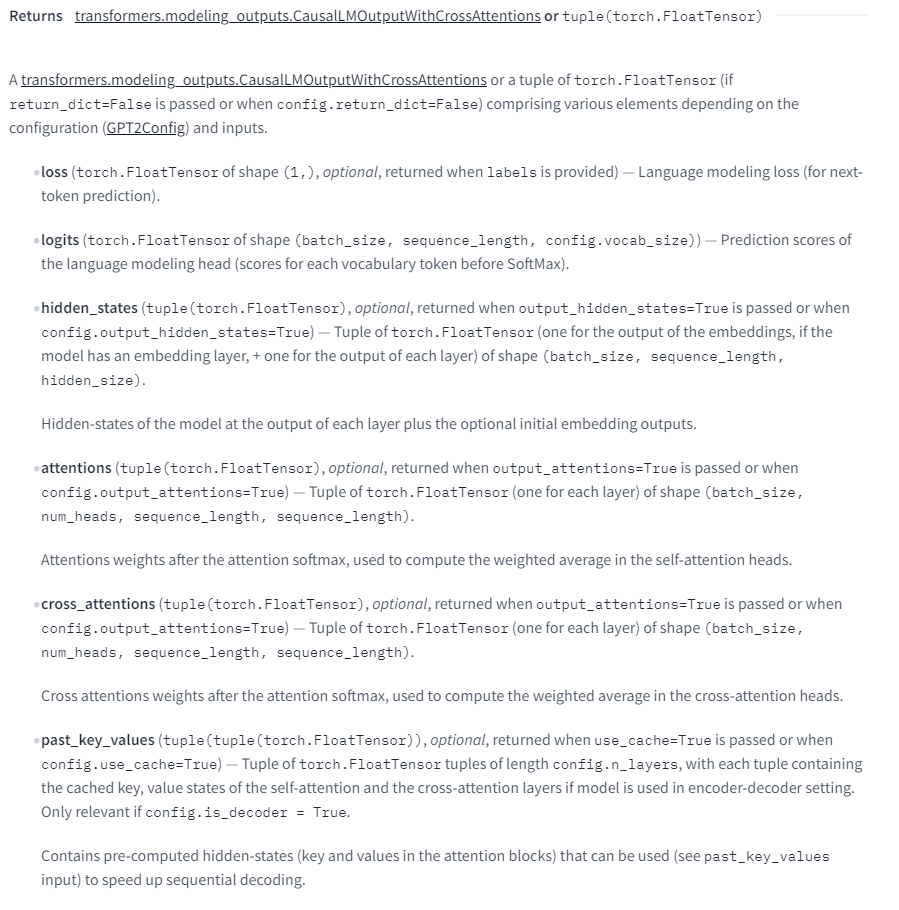

우선, 위에서 말하는 output 중 저희가 실제로 활용했던 것은 logits, loss, past_key_values입니다. logit은 위의 설명에서 보이는 것과 같이, prediction score로, 흔한 language model의 output입니다. 즉, 각 토큰에 대한 확률분포 정도라고 볼 수 있습니다.

앞서, 코드에서는 loss가 cross entropy loss라고 했는데, 실제로, GPT2LMHeadModel의 코드에서 해당 loss가 계산된 부분을 보게 되면,

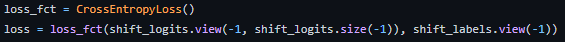

cross Enropy loss인 것을 볼 수 있습니다.

past_key_values는 설명상, 트렌스포머의 attention block에서 key, value에 대한 hidden state라고 하는데, 이를 활용하면, 마지막에 새로운 input이 하나 들어왔다고 하면 그 input만 넣게 해 디코더의 빠른 작동을 도와주는 것이라고 합니다. 즉, 지금까지 다룬 메시지에 대한 맥락이라고 볼 수 있는 것입니다.

# 참고

[챗봇 코드](https://github.com/LHolten/DialoGPT-MMI-decoder)

[DialoGPT 공식 깃허브](https://github.com/microsoft/DialoGPT)

[GPT2 공식문서](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel)

[GPT2LMHeadModel](https://github.com/huggingface/transformers/blob/v4.25.1/src/transformers/models/gpt2/modeling_gpt2.py#L945)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 34.6 MB/s 
     |████████████████████████████████| 7.6 MB 65.5 MB/s 
     |████████████████████████████████| 182 kB 72.8 MB/s 


In [ ]:
%cd drive/MyDrive/Dialo

/content/drive/MyDrive/Dialo


In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from config import device_f, device_r, num_samples, MMI_temperature, top_k

torch.set_grad_enabled(False)

tokenizer = GPT2Tokenizer('medium/vocab.json', 'medium/merges.txt')

weights = torch.load('medium/medium_ft.pkl')
# fix misused key value
weights["lm_head.weight"] = weights["lm_head.decoder.weight"]
weights.pop("lm_head.decoder.weight", None)

cfg = GPT2Config.from_json_file('medium/config.json')
model: GPT2LMHeadModel = GPT2LMHeadModel(cfg)
model.load_state_dict(weights,strict=False)
if device_f == 'cuda':
    model.half()
model.to(device_f)
model.eval()

weights = torch.load('medium/small_reverse.pkl')
# fix misused key value
weights["lm_head.weight"] = weights["lm_head.decoder.weight"]
weights.pop("lm_head.decoder.weight", None)

reverse_model: GPT2LMHeadModel = GPT2LMHeadModel(cfg)
reverse_model.load_state_dict(weights,strict=False)
if device_r == 'cuda':
    reverse_model.half()
reverse_model.to(device_r)
reverse_model.eval()


end_token = torch.tensor([[50256]], dtype=torch.long)


def _get_response(output_token, past):
    out = torch.tensor([[]], dtype=torch.long, device=device_f)

    while True:
        util = model.forward(output_token, past_key_values=past)
        output_token, past = util['logits'],util['past_key_values']
        output_token = output_token[:, -1, :].float()
        indices_to_remove = output_token < torch.topk(output_token, top_k)[0][..., -1, None]
        output_token[indices_to_remove] = -float('Inf')
        output_token = torch.multinomial(F.softmax(output_token, dim=-1), num_samples=1)

        out = torch.cat((out, output_token), dim=1)

        if output_token.item() == end_token.item():
            break

    return out, past


def _score_response(output_token, correct_token):
    inputs = torch.cat((output_token, correct_token), dim=1)
    mask = torch.full_like(output_token, -100, dtype=torch.long)
    labels = torch.cat((mask, correct_token), dim=1)

    score = -reverse_model(inputs, labels=labels)['loss'].float()

    return score


def append_messages(old_list: list, new_list: list, truncate_length=64):
    for message in new_list:
        if message != '':
            input_token = tokenizer.encode(message, return_tensors='pt')
            input_token = torch.cat((input_token, end_token), dim=1)
            old_list.append(input_token)

    if len(old_list) == 0:
        old_list.append(end_token)

    # truncate
    total_length = 0
    for i, message in enumerate(reversed(old_list)):
        total_length += message.shape[1]
        if total_length > truncate_length:
            old_list[:] = old_list[-i:]


def generate_message(message_list: list, focus_last_message=True):
    total_input = torch.cat(message_list, dim=1).to(device_f)
    if focus_last_message:
        total_input_reversed = message_list[-1]
    else:
        total_input_reversed = torch.cat(list(reversed(message_list)), dim=1)

    past = None
    if total_input.shape[1] > 1:
        past = model(total_input[:, :-1])

    results = []
    for i in range(num_samples):
        result = _get_response(total_input[:, -1:], past['past_key_values'])
        score = _score_response(result[0].to(device_r), total_input_reversed.to(device_r))
        results.append(result + (score,))

    scores = torch.stack([x[2] for x in results], dim=0)
    winner = torch.multinomial(F.softmax(scores / MMI_temperature, dim=0), num_samples=1).item()
    # winner = torch.argmax(scores, dim=0)

    out = results[winner][0]

    return tokenizer.decode(out.tolist()[0], skip_special_tokens=True)


my_message_list = []
while True:
    print("usr >> ",end="")
    my_message = input()
    if my_message=="quit":
      print("bot >> Quit. Chating End")
      break
    append_messages(my_message_list, [my_message])
    my_response = generate_message(my_message_list)
    print('bot >>', my_response)

    append_messages(my_message_list, [my_response])

usr >> Hi
bot >> Hi! :D
usr >> I want to talk with you
bot >> I wanna talk about your username
usr >> my name?
bot >> No my username, lol.
usr >> My name is hyeseong
bot >> Hi hyeseong!
usr >> Then, what's yours?
bot >> I don't speak much english.
usr >> I think you don't want to tell your name.
bot >> It's okay though you can't know my name
usr >> Why?
bot >> Why not.
usr >> quit
bot >> Quit. Chating End
